## Fashion Mnist

In [5]:
import torch
import torch.nn as nn
from PIL import Image
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

import os
import math

In [6]:
import pandas as pd

In [7]:
import torch.nn.functional as F

## Creating image dataset from csv

### Reading Csv

In [8]:
df_train = pd.read_csv("data/fashion-mnist_train.csv")

In [9]:
df_valid = pd.read_csv("data/fashion-mnist_test.csv")

In [10]:
df_valid.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
len(df_train), len(df_valid)

(60000, 10000)

In [15]:
(df_train.loc[0][1:])

pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Name: 0, Length: 784, dtype: int64

In [16]:
img = torch.tensor((df_train.loc[0][1:])).view(28,28)

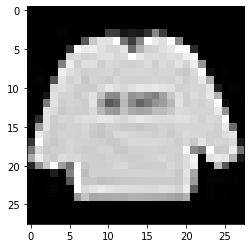

In [17]:
plt.imshow(img, cmap = "gray");

### Concat vs Stack

In [18]:
img1 = torch.tensor((df_train.loc[0][1:])).view(28,28)

In [19]:
img2 = torch.tensor((df_train.loc[1][1:])).view(28,28)

In [20]:
c1 = torch.cat((img1, img2), 0)

In [21]:
c1.shape

torch.Size([56, 28])

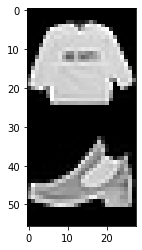

In [22]:
plt.imshow(c1, cmap = "gray");

In [23]:
c2 = torch.cat((img1, img2), 1)

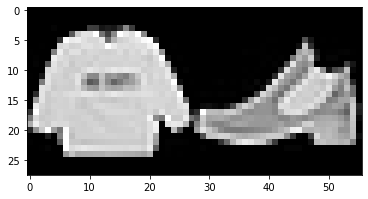

In [24]:
plt.imshow(c2, cmap = "gray");

In [29]:
s = torch.stack((img1, img2), 0)

In [30]:
s.shape

torch.Size([2, 28, 28])

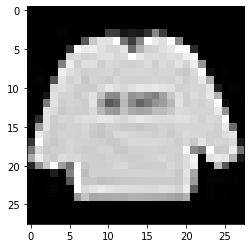

In [31]:
plt.imshow(s[0], cmap = "gray");

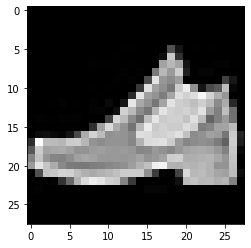

In [32]:
plt.imshow(s[1], cmap = "gray");

### Reading images and corresponding labels

In [35]:
def create_ds_from_csv(df):
    imgs, labels = [], []
    
    for i in range(len(df)):
        
        # ama. image ve labelları ayrı ayrı turmak
        imgs.append(torch.tensor(df.loc[i][1:], dtype = torch.float32).view(28,28))
        labels.append(torch.tensor(df.loc[i][0], dtype = torch.long))  # int değer kullandık çoğu lıng istiyor labelı
        
    return torch.stack(imgs), torch.stack(labels).view(-1,1)

In [36]:
trn_x, trn_y = create_ds_from_csv(df_train)

In [37]:
val_x,val_y = create_ds_from_csv(df_valid)

In [38]:
mean = trn_x.mean()
std = trn_x.std()

trn_x=(trn_x-mean)/std
mean, std, trn_x.mean(), trn_x.std()

(tensor(72.9568), tensor(89.9669), tensor(-1.9738e-05), tensor(1.))

In [39]:
val_x = (val_x-mean)/std
val_x.mean(), val_x.std()

(tensor(0.0023), tensor(1.0034))

### Our model's setup from previous lectures

In [40]:
def log_softmax(x): 
    return (x.exp()/(x.exp().sum(-1,keepdim=True)) + 1e-20).log()

In [41]:
def nll(preds, actuals): 
    return -preds[range(actuals.shape[0]), actuals].mean()

In [42]:
def validation_acc(model):
    return torch.stack([accuracy(model(xb), yb) for xb, yb in valid_dl]).mean().item()

In [43]:
def accuracy(preds, yb): 
    return (torch.argmax(preds, dim=1, keepdim = True)==yb).float().mean()

In [44]:
def loss_func(preds, targets):
    preds = log_softmax(preds)
    return nll(preds, targets)

In [45]:
def train(model, epochs=5, valid_epoch=5):
    for epoch in range(1, epochs+1):
        model = model.train()
        for xb, yb in train_dl:
            
            preds = model(xb)
            loss = loss_func(preds, yb.squeeze())
            loss.backward()
            optim.step()
            optim.zero_grad()
        
        if epoch  % valid_epoch == 0:
            model = model.eval()
            print(validation_acc(model))

## Fully connected network

In [46]:
class Dataset():
    def __init__(self, x, y): 
        self.x,self.y = x,y
    def __len__(self): 
        return len(self.x)
    def __getitem__(self, i): 
        return self.x[i].view(-1,784).cuda(),self.y[i].cuda()


class DataLoader():
    def __init__(self, ds, bs): 
        self.ds, self.bs = ds, bs
    def __iter__(self):
        n = len(self.ds)
        l = torch.randperm(n)

        
        for i in range(0, n, self.bs): 
            idxs_l = l[i:i+self.bs]
            yield self.ds[idxs_l]

In [47]:
train_ds = Dataset(trn_x, trn_y)
valid_ds = Dataset(val_x,val_y)

In [48]:
train_dl = DataLoader(train_ds, 256)
valid_dl = DataLoader(valid_ds, 256)

In [49]:
model = nn.Sequential(
    nn.Linear(784,60),
    nn.ReLU(),
    nn.Linear(60,10)
).cuda()

In [50]:
optim = torch.optim.SGD(model.parameters(), lr=0.001)

In [51]:
train(model,50,5)

0.721972644329071
0.7637695670127869
0.78125
0.798632800579071
0.8060547113418579
0.8128906488418579
0.8211914300918579
0.81982421875
0.824023425579071
0.8275390863418579


## CNN

In [52]:
class Dataset():
    def __init__(self, x, y): 
        self.x,self.y = x,y
    def __len__(self): 
        return len(self.x)
    def __getitem__(self, i): 
        return self.x[i].view(-1,1,28,28).cuda(),self.y[i].cuda()


class DataLoader():
    def __init__(self, ds, bs): 
        self.ds, self.bs = ds, bs
    def __iter__(self):
        n = len(self.ds)
        l = torch.randperm(n)

        
        for i in range(0, n, self.bs): 
            idxs_l = l[i:i+self.bs]
            yield self.ds[idxs_l]

In [53]:
train_ds = Dataset(trn_x, trn_y)
valid_ds = Dataset(val_x,val_y)

In [54]:
train_dl = DataLoader(train_ds, 256)
valid_dl = DataLoader(valid_ds, 256)

In [55]:
import torch.nn.functional as F

In [56]:
class Func(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): 
        return self.func(x)

In [57]:
def flatten(x):      
    return x.view(x.shape[0], -1)

### BatchNorm (BN)

In [58]:
# NB: PyTorch's mom parameter is opposite of what we are generally talking
# pytorch's momentum is like (1-momentum)
# nn.Module.register_buffer()
class BatchNorm(nn.Module):
    def __init__(self, nf, momentum=0.1, eps=1e-5):
        super().__init__()
       
        self.momentum,self.eps = momentum,eps
        
        self.alpha = nn.Parameter(torch.ones (nf,1,1))
        self.beta  = nn.Parameter(torch.zeros(nf,1,1))
        
        self.register_buffer('variances',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_mean_var(self, x):
        
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        
        self.means.lerp_(m, self.momentum)
        self.variances.lerp_ (v, self.momentum)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): 
                m,v = self.update_mean_var(x)
        
        else: # Do not update in inference time, use calculated valued instead
            m,v = self.means,self.variances
        
        x = (x-m) / (v+self.eps).sqrt()
        
        return x*self.alpha + self.beta

In [59]:
model = nn.Sequential(
        nn.Conv2d(1, 8, 5, padding=2,stride=2), BatchNorm(8), nn.ReLU(),  #14
        nn.Conv2d(8, 16, 3, padding=1,stride=2), BatchNorm(16), nn.ReLU(), # 7
        nn.Conv2d(16, 32, 3, padding=1,stride=2), BatchNorm(32),nn.ReLU(), # 4
        nn.Conv2d(32, 64, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Func(flatten),
        nn.Linear(64,10)
).cuda()

In [60]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

0.weight 	 torch.Size([8, 1, 5, 5])
0.bias 	 torch.Size([8])
1.alpha 	 torch.Size([8, 1, 1])
1.beta 	 torch.Size([8, 1, 1])
1.variances 	 torch.Size([1, 8, 1, 1])
1.means 	 torch.Size([1, 8, 1, 1])
3.weight 	 torch.Size([16, 8, 3, 3])
3.bias 	 torch.Size([16])
4.alpha 	 torch.Size([16, 1, 1])
4.beta 	 torch.Size([16, 1, 1])
4.variances 	 torch.Size([1, 16, 1, 1])
4.means 	 torch.Size([1, 16, 1, 1])
6.weight 	 torch.Size([32, 16, 3, 3])
6.bias 	 torch.Size([32])
7.alpha 	 torch.Size([32, 1, 1])
7.beta 	 torch.Size([32, 1, 1])
7.variances 	 torch.Size([1, 32, 1, 1])
7.means 	 torch.Size([1, 32, 1, 1])
9.weight 	 torch.Size([64, 32, 3, 3])
9.bias 	 torch.Size([64])
13.weight 	 torch.Size([10, 64])
13.bias 	 torch.Size([10])


In [61]:
for name, param in model.named_parameters():
    print(name)

0.weight
0.bias
1.alpha
1.beta
3.weight
3.bias
4.alpha
4.beta
6.weight
6.bias
7.alpha
7.beta
9.weight
9.bias
13.weight
13.bias


In [62]:
optim = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3)

In [63]:
train(model,80,10)

0.688671886920929
0.720996081829071
0.7510742545127869
0.7591797113418579
0.7720703482627869
0.7763671875
0.781542956829071
0.7948242425918579


#### BN after ReLU

In [574]:
model = nn.Sequential(
        nn.Conv2d(1, 8, 5, padding=2,stride=2, bias = False), nn.ReLU(), nn.BatchNorm2d(8), #14
        nn.Conv2d(8, 16, 3, padding=1,stride=2, bias = False), nn.ReLU(),nn.BatchNorm2d(16), # 7
        nn.Conv2d(16, 32, 3, padding=1,stride=2, bias = False), nn.ReLU(),nn.BatchNorm2d(32), # 4
        nn.Conv2d(32, 64, 3, padding=1,stride=2, bias = False), nn.ReLU(),nn.BatchNorm2d(64), # 2
        #Func(print_t),
        nn.AdaptiveAvgPool2d(1),
        Func(flatten),
        nn.Linear(64,10)
).cuda()

In [575]:
optim = torch.optim.SGD(model.parameters(), lr=0.01)

In [576]:
train(model,50,10)

0.8701042532920837
0.8764192461967468
0.8714714050292969
0.8866015672683716
0.8948112726211548


#### BN before ReLU

In [552]:
model = nn.Sequential(
        nn.Conv2d(1, 8, 5, padding=2,stride=2, bias = False),nn.BatchNorm2d(8), nn.ReLU(),  #14
        nn.Conv2d(8, 16, 3, padding=1,stride=2, bias = False),nn.BatchNorm2d(16), nn.ReLU(), # 7
        nn.Conv2d(16, 32, 3, padding=1,stride=2, bias = False), nn.BatchNorm2d(32),nn.ReLU(), # 4
        nn.Conv2d(32, 64, 3, padding=1,stride=2, bias = False), nn.BatchNorm2d(64), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Func(flatten),
        nn.Linear(64,10)
).cuda()

In [553]:
optim = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3)

In [554]:
train(model,80,10)

0.8226367235183716


KeyboardInterrupt: 

#### With BN and our custom init function

In [419]:
def gain(a):
    return math.sqrt(2.0 / (1 + a**2))

In [420]:
# kaiming for uniform init
def kaiming_uniform(x, a):
    n = x[0].shape.numel()
    std = gain(a) / math.sqrt(n)
    bound = math.sqrt(3.) * std
    x.data.uniform_(-bound, bound)

In [421]:
model = nn.Sequential(
        nn.Conv2d(1, 8, 5, padding=2,stride=2), nn.ReLU(), nn.BatchNorm2d(8), #14
        nn.Conv2d(8, 16, 3, padding=1,stride=2), nn.ReLU(),nn.BatchNorm2d(16), # 7
        nn.Conv2d(16, 32, 3, padding=1,stride=2), nn.ReLU(),nn.BatchNorm2d(32), # 4
        nn.Conv2d(32, 64, 3, padding=1,stride=2), nn.ReLU(),nn.BatchNorm2d(64), # 2
        #Func(print_t),
        nn.AdaptiveAvgPool2d(1),
        Func(flatten),
        nn.Linear(64,10)
).cuda()

In [422]:
for l in model:
    if isinstance(l, nn.Conv2d):
        kaiming_uniform(l.weight, a = 0)
        l.bias.data.zero_()

In [64]:
optim = torch.optim.SGD(model.parameters(), lr=0.01)

In [66]:
train(model,80,10)

0.8062500357627869
0.811230480670929
0.8133789300918579
0.808789074420929
0.81640625
0.8128906488418579
0.821972668170929
0.8226562738418579


## ResBlock

#### x without ReLU

In [445]:
class ResBlock(nn.Module):
    
    def __init__(self, nf):
        super().__init__()
        self.conv1 = nn.Conv2d(nf, nf, 3, padding=1,stride=1)
        self.conv2 = nn.Conv2d(nf, nf, 3, padding=1,stride=1)
        
    def forward(self, x):
        return x + self.conv2(self.conv1(x))

In [446]:
model = nn.Sequential(
        nn.Conv2d(1, 8, 5, padding=2,stride=2), nn.ReLU(), nn.BatchNorm2d(8),
        ResBlock(8),
        nn.Conv2d(8, 16, 3, padding=1,stride=2), nn.ReLU(),nn.BatchNorm2d(16), 
        ResBlock(16),
        nn.Conv2d(16, 32, 3, padding=1,stride=2), nn.ReLU(),nn.BatchNorm2d(32),
        ResBlock(32),
        nn.Conv2d(32, 32, 3, padding=1,stride=2), nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        Func(flatten),
        nn.Linear(32,10)
).cuda()

In [447]:
optim = torch.optim.SGD(model.parameters(), lr=0.01)

In [427]:
optim = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3)

In [432]:
train(model,80,10)

0.5810156464576721
0.8605338931083679
0.8770443201065063
0.891894519329071
0.8917903900146484
0.8946093916893005
0.8959831595420837
0.9000846743583679


#### x with ReLU

In [448]:
class ResBlock(nn.Module):
    
    def __init__(self, nf):
        super().__init__()
        self.conv1 = nn.Conv2d(nf, nf, 3, padding=1,stride=1)
        self.conv2 = nn.Conv2d(nf, nf, 3, padding=1,stride=1)
        
    def forward(self, x):
        return x + F.relu(self.conv2(self.conv1(x)))

In [449]:
model = nn.Sequential(
        nn.Conv2d(1, 8, 5, padding=2,stride=2), nn.ReLU(), nn.BatchNorm2d(8),
        ResBlock(8), nn.ReLU(), nn.BatchNorm2d(8),
        nn.Conv2d(8, 16, 3, padding=1,stride=2), nn.ReLU(),nn.BatchNorm2d(16), 
        ResBlock(16), nn.ReLU(), nn.BatchNorm2d(16),
        nn.Conv2d(16, 32, 3, padding=1,stride=2), nn.ReLU(),nn.BatchNorm2d(32),
        ResBlock(32), nn.ReLU(), nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, 3, padding=1,stride=2), nn.ReLU(), 
        #Func(print_t),
        nn.AdaptiveAvgPool2d(1),
        Func(flatten),
        nn.Linear(32,10)
).cuda()

In [450]:
optim = torch.optim.SGD(model.parameters(), lr=0.01)

In [451]:
train(model,80,10)

0.41594401001930237
0.8426367044448853
0.8749870657920837


KeyboardInterrupt: 

### DenseBlock

In [ ]:
class DenseBlock(nn.Module):
    
    def __init__(self, nf):
        super().__init__()
        self.conv1 = nn.Conv2d(nf, nf, 3, padding=1,stride=1)
        self.conv2 = nn.Conv2d(nf, nf, 3, padding=1,stride=1)
        
    def forward(self, x):
        return torch.cat((x, self.conv2(self.conv1(x))), 1)

In [362]:
model = nn.Sequential(
        nn.Conv2d(1, 8, 5, padding=2,stride=2), nn.ReLU(), nn.BatchNorm2d(8),
        DenseBlock(8),
        nn.Conv2d(16, 32, 3, padding=1,stride=2), nn.ReLU(),nn.BatchNorm2d(32), 
        DenseBlock(32),
        nn.Conv2d(64, 100, 3, padding=1,stride=2), nn.ReLU(),nn.BatchNorm2d(100),
        nn.AdaptiveAvgPool2d(1),
        Func(flatten),
        nn.Linear(100,10)
).cuda()

In [582]:
optim = torch.optim.SGD(model.parameters(), lr=0.01)

In [583]:
train(model,80,10)

RuntimeError: size mismatch, m1: [256 x 100], m2: [2304 x 600] at C:/w/1/s/windows/pytorch/aten/src\THC/generic/THCTensorMathBlas.cu:290